<a href="https://colab.research.google.com/github/harnalashok/CatEncodersFamily/blob/main/breastcancer_pca_xgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo with Wisconsin Breast cancer data set
Data source is [here](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(diagnostic)).

In [ ]:
# Last amended: 6th June, 2023

## Basics

In [ ]:
!pip install catencfamily==0.0.65

In [ ]:
# 1.0 Call libraries
import pandas as pd
import numpy as np


# 1.01
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# 1.02
import matplotlib.pyplot as plt
import seaborn as sns


# 1.03
import xgboost as xgb


# 1.04
from catencfamily.encoders import CatEncodersFamily
from catencfamily import utils

In [ ]:
# 1.05 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [ ]:
# 2.0 Read Data
data = pd.read_csv("https://raw.githubusercontent.com/harnalashok/CatEncodersFamily/main/datasets/breastcancer.csv")
data.head(3)

In [ ]:
# 2.1
data.shape   # (569, 30)
print("\n==dtypes====\n")
data.dtypes

In [ ]:
# 2.2 pop out target, id and unnamed:

y = data.pop("diagnosis")
_ = data.pop("id")
_= data.pop("Unnamed: 32")

In [ ]:
# 2.21 Map target to 0 and 1
y = y.map({"M" : 1, "B": 0 })

# 2.22 Proportions of 1s and 0s
y.value_counts(normalize = True)

In [ ]:
# 2.3 Check nulls and need for imputing?

data.isnull().sum().sum()


0

In [ ]:
# 2.4 Rename columns having spaces:

data = data.rename(columns = { "concave points_mean" : "concave_points_mean",
                               "concave points_se"   : "concave_points_se",
                               "concave points_worst": "concave_points_worst"
                             }
                   )    


## Transform numeric data to categorical
We transform our data as if it were categorical. (of course, such transformation is imperfect.)

To perform our experiments we bin all numeric columns to transform the data to categorical. Binning is performed using pandas `cut()` method. Subsequently we will transform the categorical data to numeric using the approach given in CatEncodersFamily.  

While binning, we also split the data: both the numeric (the original) as also the binned datasets. Spliting is performed in stratified manner using `train_test_split()` function of sklearn; `target (y)` is used to stratify. While splitting, for easy comparison, we  see to it that same set of rows occur in orig_train and train_binned on the one hand and orig_test and test_binned on the other hand. 

In [ ]:
# 3.0 Discretise all features of data. And also split dataset.
#     into train/test:

orig_train, orig_test, train_binned, test_binned  = utils.transformToCatFeatures(data,
                                                                              y,
                                                                              bins = 30,
                                                                              test_size = 0.1,
                                                                              genColName = False  # Keep orig col names
                                                                              )

In [ ]:
# 3.0.1 Check  original data:
#       It has target col also:

orig_train.shape
print("\n======\n")
orig_train.head(3)
orig_test.head(3)


In [ ]:
# 3.0.2 Check discretised features
#       Note the row-indices of train/test data 
#       and compare with those in the above cell.

train_binned.shape
print("\n========\n")
train_binned.head(3)
test_binned.head(3)

In [ ]:
# 3.1 Pop out targets:
ytr = train_binned.pop('target')
yte = test_binned.pop("target")

## Transform categorical data to numeric
We use `CatEncodersFamily` class for transformation:

In [ ]:
## 4.0 Developing models
#      Which are our cat columns
#      We will consider top-5 features 
# Ref: https://www.kaggle.com/code/kanncaa1/feature-selection-and-data-visualization

best_features= ["area_mean", "area_se", "texture_mean", "concavity_worst", "concavity_mean"]
cat_cols = list(train_binned[best_features].columns)
len(cat_cols)  # 5


# 4.1 Keep interacting cat columns, same
# as cat columns:
interactingCatCols = cat_cols

5

In [ ]:
# 5.0 Instantiate CatEncodersFamily class:

ct = CatEncodersFamily(
                       cMeasures=[1,1,1,1,None,1,1],
                       )

# 5.1 Fit it using only train_binned dataset.
#     While fitting, 'target' is not needed:


ct.fit(train_binned, cat_cols, interactingCatCols) 

## Data transformation:

In [ ]:
# 6.0 Transform both test_binned and train_binned data:

test_trans = ct.transform(test_binned[cat_cols])

f"Transformed test data shape: {test_trans.shape}"

In [ ]:
# 6.0.1 Transform train_binned now:

train_trans= ct.transform(train_binned[cat_cols])

f"Transformed train data shape: {train_trans.shape}"

Our new features are substantially difft from original features. Prefixes to feature names imply as below:  
<i>
>deg_ ===> This feature results from calculation of degree centrality<br>
>eig_ ===> This feature results from calculation of eigenvector centrality<br>
>pr_  ===> This feature results from calculation of page rank centrality<br>
>bet_ ===> This feature results from calculation of betweenness centrality<br>
>clu_ ===> This feature results from calculation of clustering characteristics<br>,</i>


In [ ]:
# 6.1 Observe data now:
#     It also has original binned cols (5):

train_trans.head()
test_trans.head()

In [ ]:
# 6.2

_= orig_train.pop('target')
_= orig_test.pop('target')

## PCA with original data and transformed data:

In [ ]:
# 7.0 PCA with original train data:

pca = PCA(n_components = 2,  whiten= True, random_state= None)
ss= StandardScaler()
orig_pca = pca.fit_transform(ss.fit_transform(orig_train[cat_cols]))
orig_pca.shape

In [ ]:
# 7.1 PCA with transformed data.
#     Drop the five cat_cols first:

trans_pca = train_trans.iloc[:,len(cat_cols):]
trans_pca.isnull().sum().sum()  # If not null perform imputation with SimpleImputer(strategy = 'median')

In [ ]:
# 7.2 PCA of transformed data:

pca = PCA(n_components= 2, whiten= True, random_state = None)
ss = StandardScaler()
trans_pca = pca.fit_transform(ss.fit_transform(trans_pca))
trans_pca.shape

In [ ]:
# 7.3 Assign column names;

colnames = ["pc" + str(i) for i in range(orig_pca.shape[1])]
orig_pca  = pd.DataFrame(orig_pca, columns = colnames)
trans_pca = pd.DataFrame(trans_pca, columns = colnames)

In [ ]:
# 8.1 PCA from original train data:

plt.style.use("dark_background")
sns.scatterplot(data = orig_pca ,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA of original numeric data');


In [ ]:
# 8.2 PCA from transformed data:

plt.style.use("dark_background")
sns.scatterplot(data = trans_pca,
                x= 'pc0',
                y = 'pc1',
                hue = ytr.values,
                palette = ["#33cc33", "#cc0000"]
                ).set(title='PCA from transformed data') ;

## xgboost modeling:

In [ ]:
# 9.0 Original train/test data:

evals_result= {}
model_orig = xgb.XGBClassifier( n_estimators= 200,
                               verbosity = 3,
                               eta = 0.06,      
                               max_depth = 6,
                               subsample = 0.8, 
                               evals_result = evals_result,
                               random_state = 70,
                              )


tr_X =   orig_train[best_features] 
test_X = orig_test[best_features]  
ytr = ytr 
yte = yte 


model_orig.fit(tr_X, ytr.values,             
               early_stopping_rounds = 50,   
               eval_set=[ (test_X, yte.values)],
               eval_metric = ['auc']        
              )



In [ ]:
# 9.1 Scores:

f"Best auc from orig train/test data: {model_orig.best_score}"
print("\n===========\n")
f"Best iteration from orig train/test data: {model_orig.best_iteration}"

'Best auc from orig train/test data: 0.9939393939393939'

'Best iteration from orig train/test data: 38'

In [ ]:
# 9.2 Modeling with transformed train/test data:

evals_result= {}
model_trans = xgb.XGBClassifier( n_estimators= 80,
                           verbosity = 3,
                           eta = 0.06,      
                           max_depth = 6,
                           subsample = 0.8,        
                           evals_result = evals_result,
                           random_state = 70,
                           )


tr_X =   train_trans.iloc[:,len(cat_cols):]
test_X = test_trans.iloc[:,len(cat_cols):]
ytr = ytr 
yte = yte 


model_trans.fit(tr_X, ytr.values,     
          early_stopping_rounds = 50, 
          eval_set=[ (test_X, yte.values)],
          eval_metric = ['auc']    
          )



In [ ]:
# 9.3

f"Best auc from transformed train/test data: {model_trans.best_score}"
print("\n===========\n")
f"Best iteration from transformed train/test data: {model_trans.best_iteration}"

'Best auc from transformed train/test data: 0.9949494949494949'

'Best iteration from transformed train/test data: 19'

## Distribution of columns
Distribution of columns related to different centrality measures

In [ ]:
colList = (train_trans.iloc[:,len(cat_cols):]).columns
f = utils.featureImptByCentrality(colList, True)

In [ ]:
f

eigenvector          0.259259
degree               0.185185
pagerank             0.185185
clusteringcoeff      0.185185
betweenness          0.185185
avgembeddedness      0.000000
leidencomsdensity    0.000000
dtype: float64

In [ ]:
fe_1, fe_0,_ = utils.xgImptFeatures(model_trans, colList)
f"Columns whose impt is >0: {len(fe_1)}"
f"Columns whose impt is 0: {len(fe_0)}"


Order of feature importance is by 'gain'


'Columns whose impt is >0: 160'

'Columns whose impt is 0: 110'

In [ ]:
t = featureImptByCentrality(fe_1, True)
t

eigenvector          0.3125
clusteringcoeff      0.2000
degree               0.1875
pagerank             0.1750
betweenness          0.1250
avgembeddedness      0.0000
leidencomsdensity    0.0000
dtype: float64

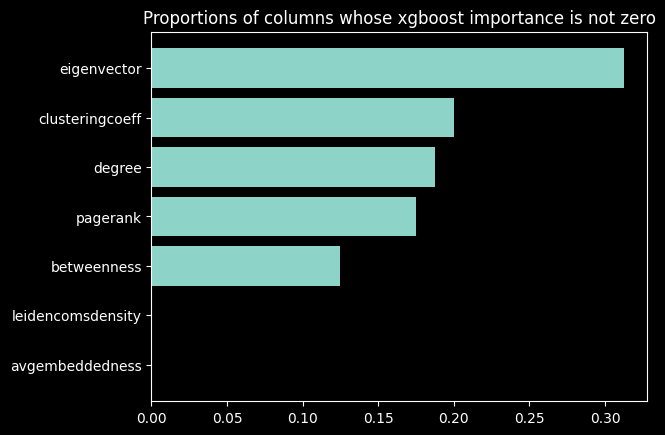

In [ ]:
plotSeries(t, "Proportions of columns whose xgboost importance is not zero")

In [ ]:
fe_1, fe_0, fe = utils.xgImptFeatures(model_trans, colList)

In [ ]:
d = utils.featureImptByCentFeatCounts(colList)

d

eigenvector          70
degree               50
pagerank             50
clusteringcoeff      50
betweenness          50
avgembeddedness       0
leidencomsdensity     0
dtype: int64

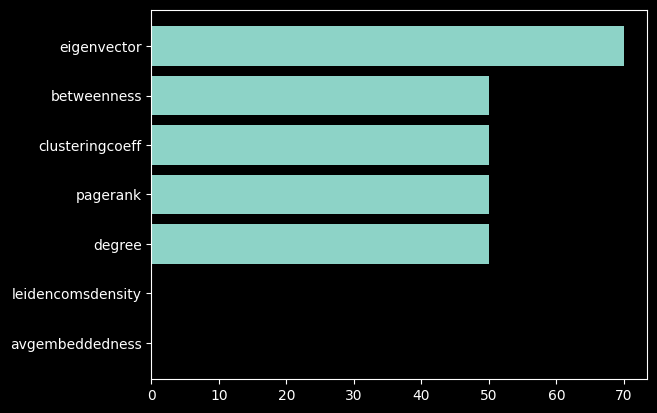

In [ ]:
plotSeries(d)

In [ ]:
score = fe['imp']

In [ ]:
score

deg_area_se_ck_texture_mean                      0.102290
deg_concavity_mean_ck_concavity_worst            0.055836
eig_concavity_mean_ck_texture_mean               0.052912
deg_concavity_worst_ck_area_se_p_texture_mean    0.035450
clu_area_mean_ck_area_se                         0.029509
                                                   ...   
deg_texture_mean_ck_concavity_worst              0.000000
bet_area_se_ck_area_mean_p_concavity_worst       0.000000
deg_area_se_ck_texture_mean_p_concavity_worst    0.000000
eig_area_se_ck_texture_mean_p_concavity_worst    0.000000
deg_area_se_ck_area_mean_p_texture_mean          0.000000
Name: imp, Length: 270, dtype: float32

In [3]:

g = utils.featureImptByScore(score, colList, True)

NameError: ignored

In [ ]:
g.sum()

1.0000001

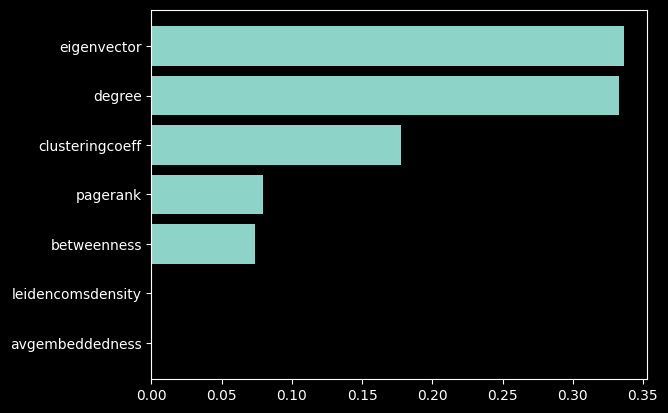

In [ ]:
plotSeries(g)

## Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_classif



In [ ]:
mi_scores = utils.calMIScores(train_trans[colList], ytr)
mi_scores[::3]  # show a few features with their MI scores

In [ ]:
fe.cumsum()
len(fe)

In [ ]:
fe['imp'].cumsum().values

In [ ]:
plt.plot(range(len(fe)), fe['imp'].cumsum().values)
plt.grid()

In [ ]:
plt.plot(range(len(mi_scores)), mi_scores.cumsum().values)
plt.grid()

In [ ]:
sns.histplot(mi_scores)

In [ ]:
# 7.1
plt.figure(dpi=100, figsize=(8, 20))
plot_mi_scores(mi_scores);